<a href="https://colab.research.google.com/github/thdudgus/Pythons-in-AI/blob/main/241107_MLP_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [1]:
import os # Provides a way to interact with the operating system, such as file operations.
import csv # Enables reading and writing CSV files, which are commonly used for tabular data.
import numpy as np
from tqdm.notebook import tqdm

# A plotting library for creating visualizations such as charts, histograms, and scatter plots.
import matplotlib.pyplot as plt
# The Python Imaging Library, used for image processing tasks such as opening, manipulating, and saving images.
from PIL import Image

import torch
# provides datasets, transforms, and common architectures for computer vision tasks.
import torchvision
from torchvision import transforms
# Contains neural network layers, loss functions, and utilities for building neural networks.
import torch.nn as nn
# Provides functional interface to neural network operations like activation functions and loss functions.
import torch.nn.functional as F
# Contains optimization algorithms such as SGD, Adam, RMSprop, etc. for training neural networks.
import torch.optim as optim
# Provides utilities for handling datasets and data loading in PyTorch.
from torch.utils.data import Dataset, DataLoader

# Printing PyTorch version
print(torch.__version__)

2.5.1+cu121


### MNIST dataset is provided from Google Colab by default

In [2]:
# Setting paths for train and test data
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [3]:
# Choosing device: GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28x28 for image


In [4]:
# MNIST 데이터셋을 CSV 파일에서 읽어오는 함수
def mnist_reader(file_path, img_size=img_size):
    # 이미지와 레이블을 저장할 리스트 초기화
    total_img = list()
    total_label = list()

    # CSV 파일 열기
    with open(file_path) as csvfile:
        # CSV 리더 생성
        mnist_reader = csv.reader(csvfile)
        # CSV 파일의 각 행 반복
        for row in mnist_reader:
            # 픽셀 값을 NumPy 배열로 변환하고 28x28로 변형
            img = np.array(row[1:], dtype=np.uint8).reshape(img_size, img_size)
            # 행의 첫 번째 요소에서 레이블 추출
            label = int(row[0])

            # 이미지와 레이블을 각각 리스트에 추가
            total_img.append(img)
            total_label.append(label)

    # 리스트를 NumPy 배열로 변환
    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)

    return total_img, total_label

In [5]:
# mnist_reader 함수를 사용하여 학습 및 테스트 이미지와 레이블 읽기
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

# 데이터 타입과 배열 크기 출력
print(type(train_img))
print(type(train_label))
print(train_img.shape, train_label.shape)
print(test_img.shape, test_label.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(20000, 28, 28) (20000,)
(10000, 28, 28) (10000,)


### Define the Dataset

In [6]:
# MNIST용 커스텀 데이터셋 클래스 정의
class MNIST_Dataset(Dataset):
    def __init__(self, img, label):
        # 이미지와 레이블로 데이터셋 초기화
        self.img = img
        self.label = label
        # 데이터 샘플의 총 개수 저장
        self.num_data = self.img.shape[0]

    def __len__(self):
        # 데이터 샘플의 총 개수 반환
        return self.num_data

    def __getitem__(self, idx):
        # 인덱스를 통해 샘플 가져오기
        sample = dict()

        # 이미지 픽셀 값을 [0, 1] 범위로 정규화
        sample['img'] = self.img[idx] / 255
        # 해당하는 레이블 가져오기
        sample['label'] = self.label[idx]

        return sample

### Define the DataLoader

In [7]:
# 배치 크기 설정
batch_size = 64

# 학습 및 테스트 데이터셋 클래스 인스턴스 생성
train_dataset = MNIST_Dataset(train_img, train_label)
test_dataset = MNIST_Dataset(test_img, test_label)

# 학습 및 테스트 데이터를 배치 단위로 반복 처리하기 위한 DataLoader 객체 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Sample one data point from dataloader

In [8]:
# 테스트 데이터로더에서 데이터 한 배치를 가져오기
sample = next(iter(test_dataloader))

# 샘플 배치의 이미지와 레이블 텐서 크기 출력
print(sample['img'].shape)
print(sample['label'].shape)
print(sample['label'])

torch.Size([64, 28, 28])
torch.Size([64])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


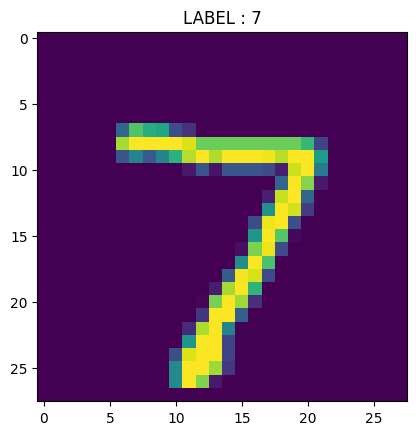

In [9]:
# 첫 번째 이미지를 시각화
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define MLPs function

In [10]:
# MLP 모델 클래스 정의
class MyModel(nn.Module):
    def __init__(self, dim_hid_1=128, dim_hid_2=128, dim_inp=img_size**2, dim_out=10):
        super(MyModel, self).__init__()

        # 은닉층, 입력, 출력 차원 초기화
        self.dim_hid_1 = dim_hid_1
        self.dim_hid_2 = dim_hid_2
        self.dim_inp = dim_inp
        self.dim_out = dim_out

        # 활성화 함수 정의 (ReLU)
        self.acti = nn.ReLU()

        # 첫 번째 블록 정의
        self.block_1 = nn.Sequential(nn.Linear(dim_inp, dim_hid_1),
                                     self.acti,
                                     )

        # 두 번째 블록 정의
        self.block_2 = nn.Sequential(nn.Linear(dim_hid_1, dim_hid_2),
                                     self.acti,
                                     )

        # 최종 출력층 정의
        self.final_layer = nn.Linear(dim_hid_2, dim_out)

    def forward(self, img):
        # 입력 이미지를 1D 텐서로 변환
        batch_size = img.shape[0]
        inp = img.view(batch_size, -1)

        # 첫 번째 블록을 거침
        out = self.block_1(inp)

        # 두 번째 블록을 거침
        out = self.block_2(out)

        # 최종 출력층을 거침
        out = self.final_layer(out)

        return out

### Create an instance of our MLP model and prepare the optimizer

In [11]:
# MLP 모델 인스턴스 정의
model = MyModel()

# 모델을 적절한 장치(CPU 또는 GPU)로 이동
model = model.to(device)

# 모델 매개변수를 학습시키기 위한 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Define functions for training and testing the model

In [12]:
# 학습 함수 정의
def train(model, optimizer, sample):
    # 모델을 '학습' 모드로 설정
    model.train()

    # 손실 함수 정의 (크로스 엔트로피 손실)
    criterion = nn.CrossEntropyLoss()

    # 샘플에서 입력 이미지와 레이블 추출
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # 모델 예측값 계산
    pred = model(img)

    # 정확히 예측한 샘플 개수 계산
    num_correct = sum(torch.argmax(pred, dim=1) == label)

    # 손실 계산
    pred_loss = criterion(pred, label)

    # 역전파 및 가중치 업데이트 수행
    optimizer.zero_grad()
    pred_loss.backward()
    optimizer.step()

    # 손실 값과 정확히 예측한 샘플 개수 반환
    return pred_loss.item(), num_correct.item()

In [13]:
# 테스트 함수 정의
def test(model, sample):
    # 모델을 '평가' 모드로 설정
    model.eval()

    # 손실 함수 정의 (크로스 엔트로피 손실)
    criterion = nn.CrossEntropyLoss()

    # 샘플에서 입력 이미지와 레이블 추출
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # 계산 그래프 비활성화 (효율성을 위해)
    with torch.no_grad():
        # 모델 예측값 계산
        pred = model(img)

        # 손실 계산
        pred_loss = criterion(pred, label)

        # 정확히 예측한 샘플 개수 계산
        num_correct = sum(torch.argmax(pred, dim=1) == label)

    # 손실 값과 정확히 예측한 샘플 개수 반환
    return pred_loss.item(), num_correct.item()

### Run the MLP model

In [ ]:
# 최대 학습 에포크 수 정의
max_epoch = 100

# 학습 및 테스트 정확도를 출력할 빈도 설정
print_stride = 10

# 학습 및 테스트 손실을 저장할 리스트 초기화
tr_loss_saver = []
te_loss_saver = []

# 에포크 반복
for epoch in tqdm(range(max_epoch)):
    ### 학습 단계
    train_loss = 0.0  # 학습 손실 초기화
    train_accu = 0.0  # 학습 정확도 초기화

    # 학습 데이터로더 반복
    for idx, sample in enumerate(train_dataloader):
        # 학습 단계를 수행하고 현재 손실 및 정확히 예측한 개수 계산
        curr_loss, num_correct = train(model, optimizer, sample)
        # 손실 및 정확도 누적
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # 학습 손실 저장
    tr_loss_saver.append(train_loss)

    # 현재 모델 매개변수 저장
    torch.save(model.state_dict(), 'recent.pth')

    ### 테스트 단계
    test_loss = 0.0  # 테스트 손실 초기화
    test_accu = 0.0  # 테스트 정확도 초기화

    # 테스트 데이터로더 반복
    for idx, sample in enumerate(test_dataloader):
        # 테스트 단계를 수행하고 현재 손실 및 정확히 예측한 개수 계산
        curr_loss, num_correct = test(model, sample)
        # 손실 및 정확도 누적
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    # 테스트 손실 저장
    te_loss_saver.append(test_loss)

    # 지정된 에포크마다 학습 및 테스트 정확도 출력
    if (epoch+1) % print_stride == 0:
        print('[epoch {}] train accu :{:.2f} , test accu :{:.2f}'.format(epoch+1, train_accu, test_accu))


  0%|          | 0/100 [00:00<?, ?it/s]

[epoch 10] train accu :0.93 , test accu :0.93
[epoch 20] train accu :0.95 , test accu :0.94
[epoch 30] train accu :0.97 , test accu :0.95
[epoch 40] train accu :0.98 , test accu :0.96
[epoch 50] train accu :0.99 , test accu :0.96
[epoch 60] train accu :0.99 , test accu :0.96
[epoch 70] train accu :1.00 , test accu :0.96
[epoch 80] train accu :1.00 , test accu :0.96
[epoch 90] train accu :1.00 , test accu :0.97


### Plot the train and test loss

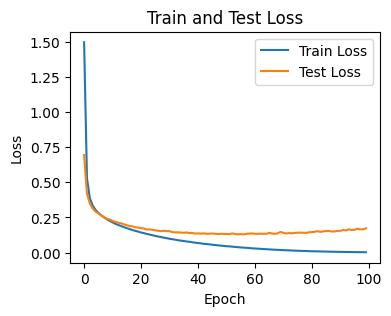

In [ ]:
# 학습 및 테스트 손실 시각화
plt.figure(figsize=(4, 3))
plt.plot(tr_loss_saver)  # 학습 손실 그래프
plt.plot(te_loss_saver)  # 테스트 손실 그래프
plt.legend(['Train Loss', 'Test Loss'])  # 범례 추가
plt.xlabel('Epoch')  # x축 레이블
plt.ylabel('Loss')  # y축 레이블
plt.title('Train and Test Loss')  # 그래프 제목
plt.show()  # 그래프 표시